In [61]:
import pandas as pd
from helpers import *
from sklearn.model_selection import  GridSearchCV
from xgboost import XGBClassifier
from aif360.sklearn.preprocessing import Reweighing, LearnedFairRepresentations

## Preprocessing models


Preprocessing bias mitigation models involve adjusting the input data before it is fed into a machine learning algorithm to reduce or eliminate biases, ensuring fairer and more equitable outcomes.

In [62]:
## Load the pre-processed dataset.
df=pd.read_csv("./data/standard_df.csv")

## Create a list with the protected attributes that are going to be used. 
prot_attr=['Previous_qualification', 'Debtor', 'Tuition_fees_up_to_date']

In [63]:
## Split the dataset and standardize it. 

X_train, X_test, y_train, y_test, indices_train, indices_test=standardized_dataset_output(
                                                                                            df,
                                                                                            prot_attr,
                                                                                            'Target'
                                                                                        )



In [64]:
## Create two lists of metrics: one for the evaluation metrics and one for the fairness metrics.
eval_metrics=['Balanced Accuracy', 'f1-score', 'ROC-AUC']
fairness_metrics=['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']

### Reweighing

In [65]:
## The model object
model=XGBClassifier()
## The parameters to be used on GridSearchCV.
params={'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01, 0.001]}

## The score to be used on GridSearchCV.
scorer=make_scorer(scoring_func, scoring="statistical_parity", greater_is_better=False, pret_attr=prot_attr[1])

In [66]:
## Create the weights based on the protective attribute. 
weights=Reweighing(prot_attr).fit_transform(X_train, y_train)[1]

## Initialize GridSearchCV
grid=GridSearchCV(model, params, scoring=scorer, cv=5, n_jobs=4).fit(X_train, y_train, sample_weight=weights)

## Define the predictions
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [67]:
## Calculate all the evaluation and fairness metrics of eahch protective attribute. 
reweighing_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

In [68]:
reweighing_df.to_csv("./data/reweighing_df.csv")

In [69]:
reweighing_df

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Previous_qualification,0.8785,0.914,0.9388,0.4278,2.9250,0.4481,0.2479
1,Debtor,0.8785,0.914,0.9388,0.3438,1.9949,0.1448,0.0412
2,Tuition_fees_up_to_date,0.8785,0.914,0.9388,-0.5389,0.2497,-0.1144,-0.0858


In [70]:
xgboost_df=pd.read_csv('./data/xgboost_df.csv')

xgboost_df[eval_metrics].iloc[0, :]

Balanced Accuracy    0.8934
f1-score             0.9249
ROC-AUC              0.9518
Name: 0, dtype: float64

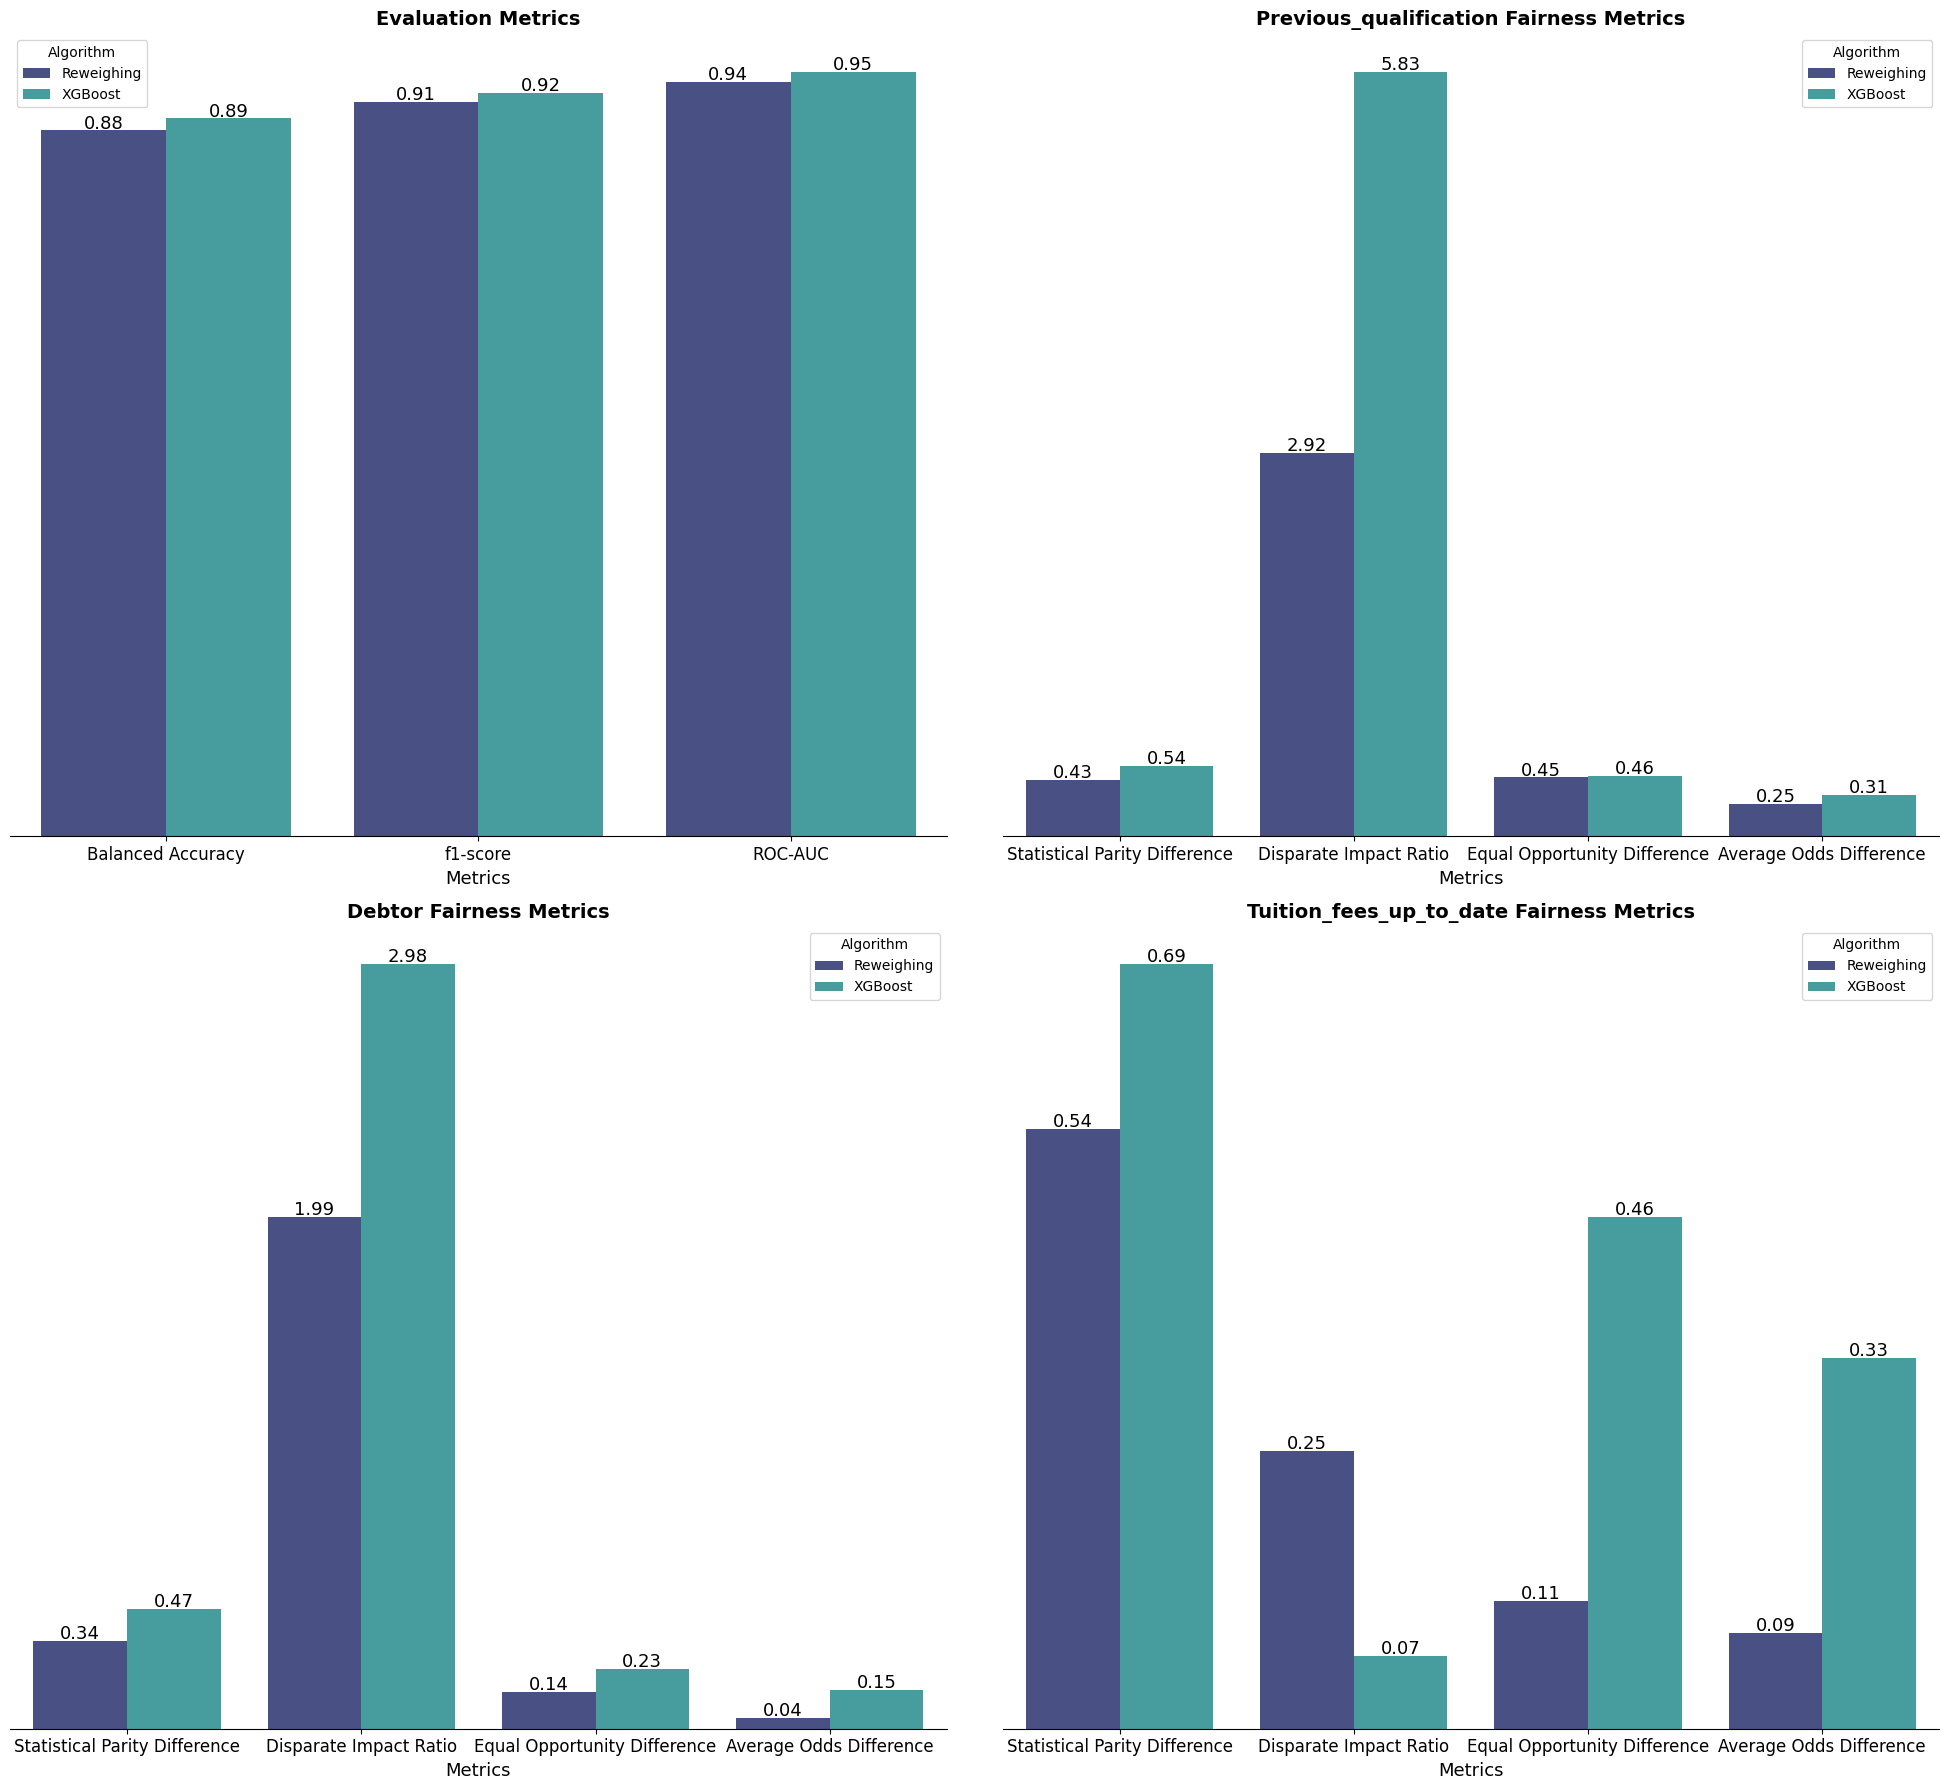

In [71]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(reweighing_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['Reweighing'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(reweighing_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['Reweighing'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


x_labels = [ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms = ['Reweighing', 'XGBoost']



# Call the function
plot_2x2_metrics(metrics_list, x_labels, algorithms)

### Learning Fair Representation

In [72]:
model=LearnedFairRepresentations(prot_attr[1], n_prototypes=25, max_iter=1000, random_state=0)
params={"reconstruct_weight": [1e-2, 1e-3, 1e-4], "target_weight": [10, 100, 1000], "fairness_weight": [0, 10, 100, 1000]}
scorer=make_scorer(scoring_func, scoring="delta", pref_attr=prot_attr[1])

In [73]:
grid=GridSearchCV(model, params, scoring=scorer, cv=5, n_jobs=4).fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

In [74]:
lfr_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

In [75]:
lfr_df.to_csv("./data/lfr_df.csv")

In [76]:
lfr_df

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Previous_qualification,0.8476,0.8972,0.8913,0.5676,6.1083,0.4511,0.3550
1,Debtor,0.8476,0.8972,0.8913,0.0560,1.0896,-0.0523,-0.2151
2,Tuition_fees_up_to_date,0.8476,0.8972,0.8913,-0.5070,0.3162,0.0507,-0.0139


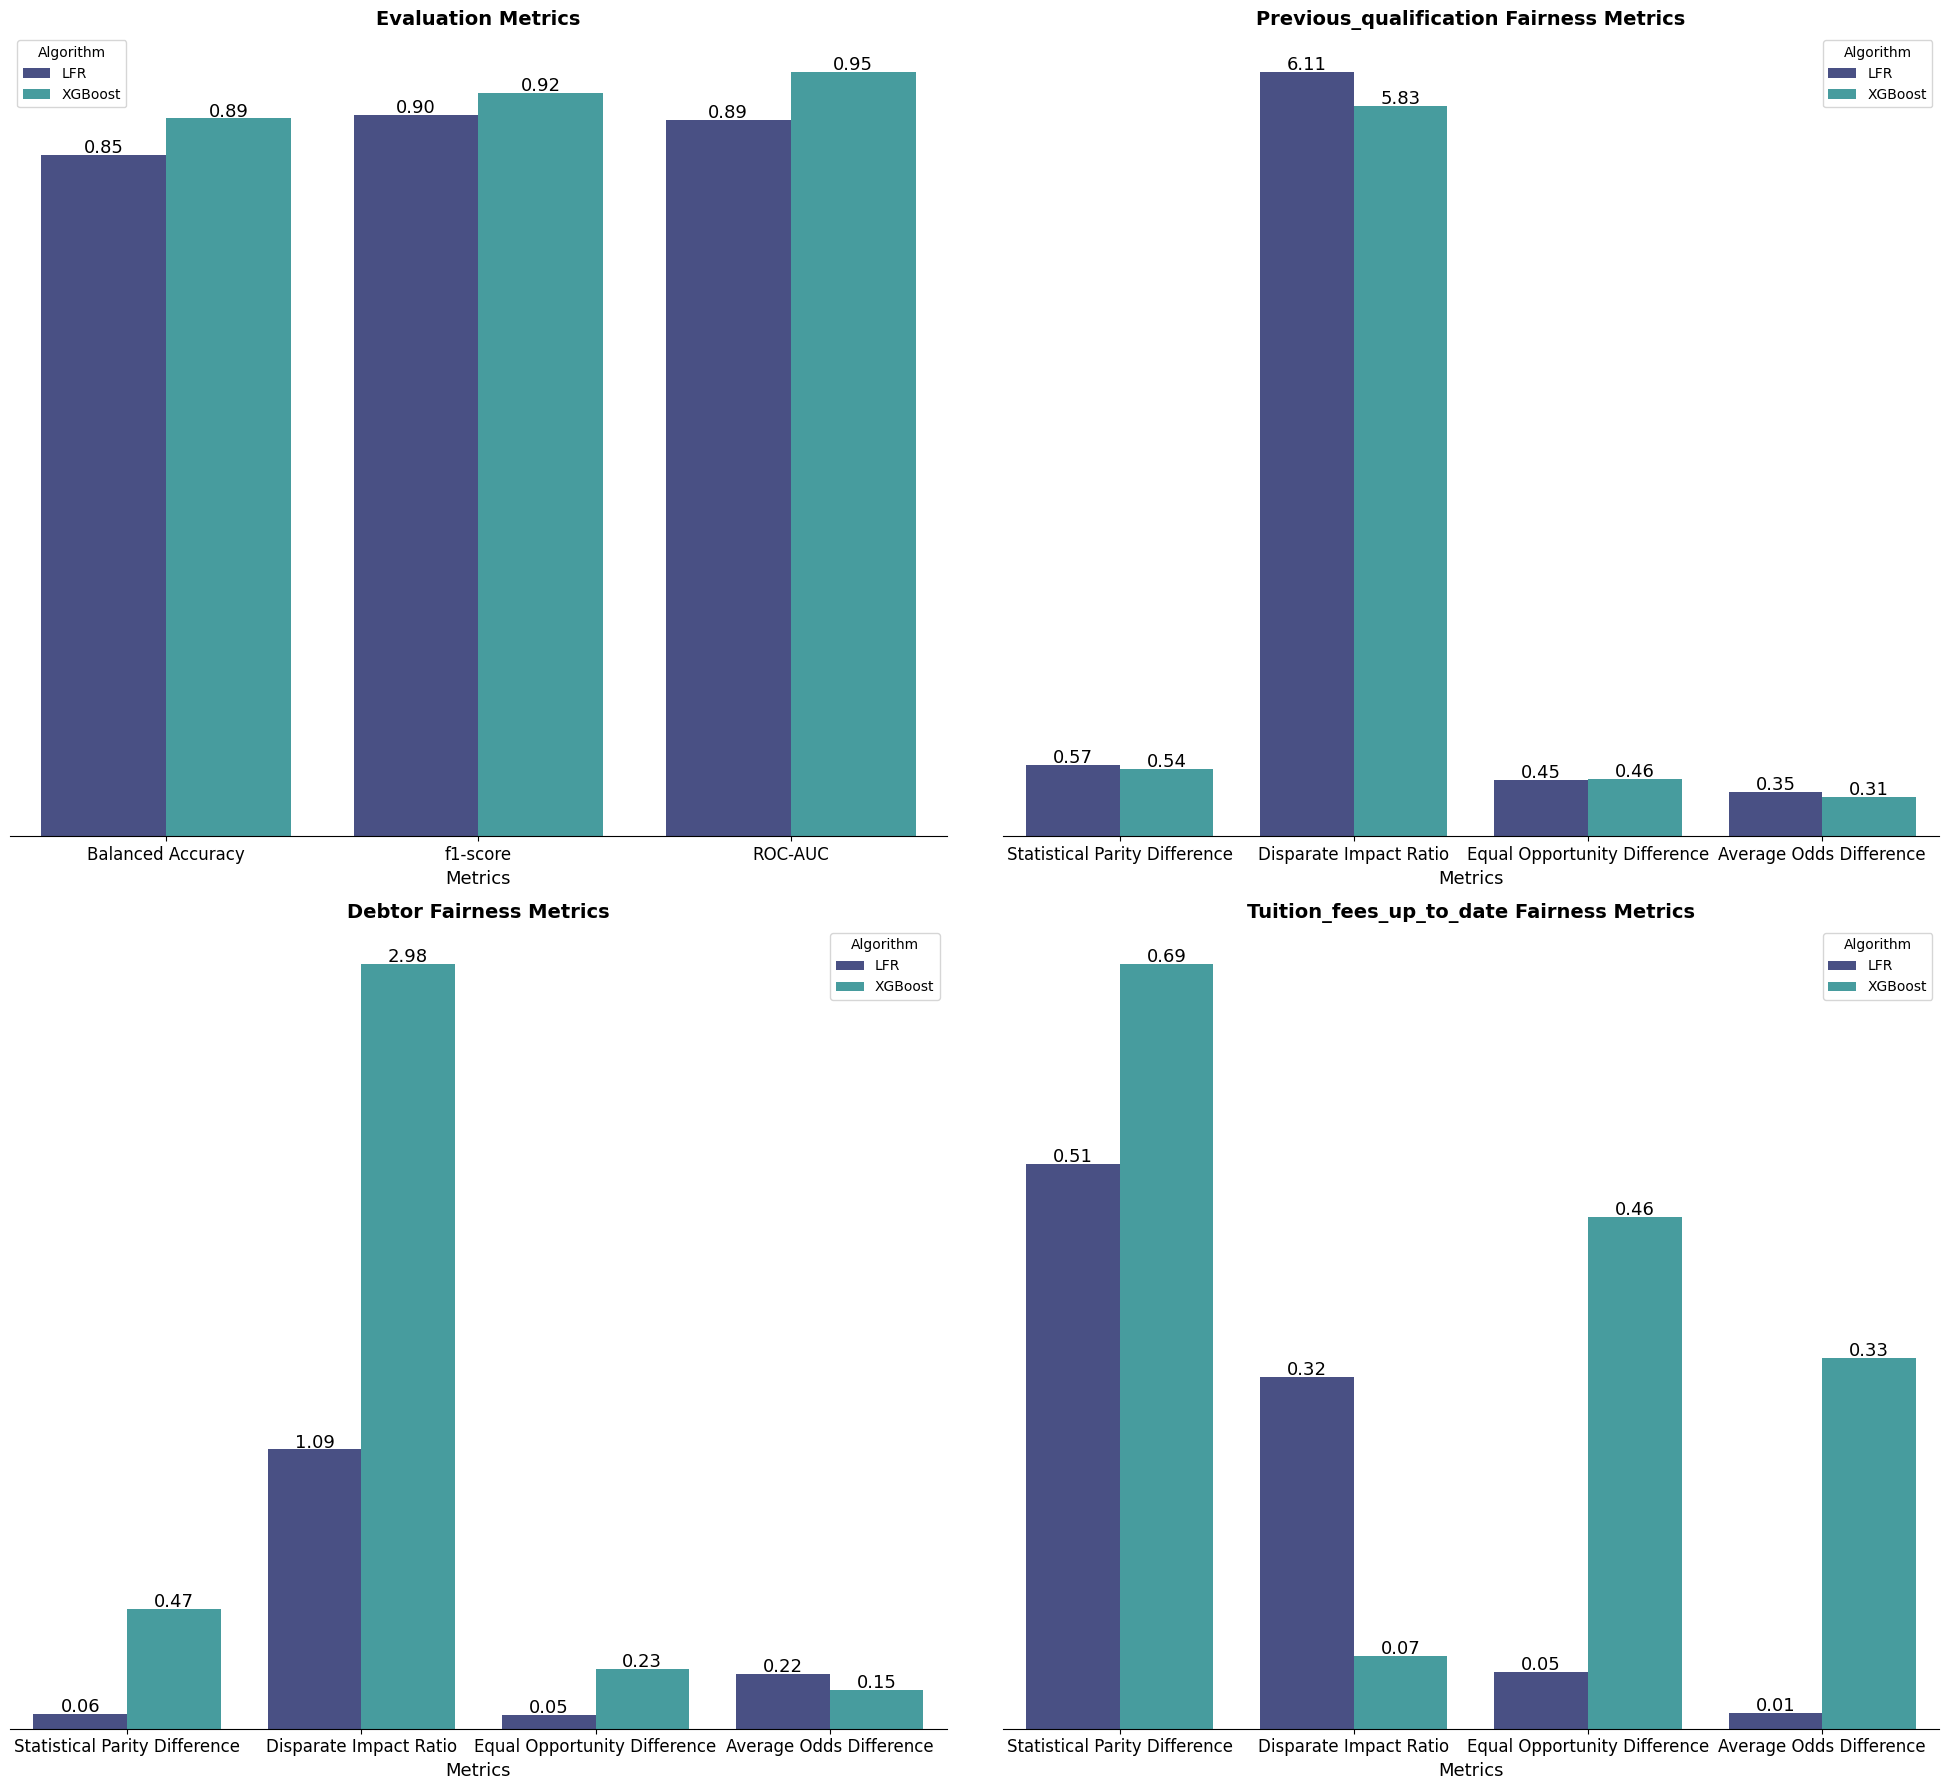

In [77]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(lfr_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['LFR'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(lfr_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['LFR'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


# metrics_list = [metrics_df1, metrics_df2, metrics_df3, metrics_df4]
labels = [ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms = ['LFR', 'XGBoost']



# Call the function
plot_2x2_metrics(metrics_list, labels, algorithms)